In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'


In [2]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())


# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'

In [3]:
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression

X, y = make_moons(n_samples=1000, noise=0.1, random_state=0)

clf = LogisticRegression()

clf.fit(X, y)

LogisticRegression()

In [4]:
p_hats = clf.predict_proba(X)[:, 1]
p_hats[:10]

array([0.60804417, 0.96671272, 0.02867904, 0.41138351, 0.9631718 ,
       0.72298419, 0.51086972, 0.0148838 , 0.01696895, 0.98714042])

In [5]:
true_labels = y
true_labels[:10]

array([1, 1, 0, 1, 1, 1, 0, 0, 0, 1])

In [6]:
df = pd.DataFrame({'p_hat': p_hats, 'y': true_labels})
df.head()

,p_hat,y
0,0.608044,1
1,0.966713,1
2,0.028679,0
3,0.411384,1
4,0.963172,1


In [7]:
# Let us look at samples where p_hat is close to 0.5 (say between 0.45 and 0.55)
df_close_phat_val = df[(df.p_hat > 0.45) & (df.p_hat < 0.55)]
df_close_phat_val.head()

,p_hat,y
6,0.510870,0
15,0.481702,0
20,0.533697,0
41,0.522857,1
60,0.483962,1


In [8]:
len(df_close_phat_val)

31

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


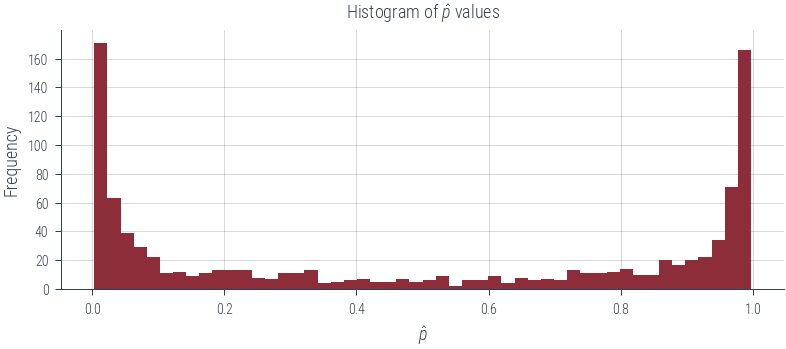

In [9]:
# Histogram of p_hat values
df.p_hat.hist(bins=50)
plt.xlabel('$\hat{p}$')
plt.ylabel('Frequency')
plt.title('Histogram of $\hat{p}$ values');

In [10]:
# Out of these len(df_close_phat_val) samples, how many are actually positive? 

df_close_phat_val.y.sum()

18

In [11]:
# Fraction of positive samples
df_close_phat_val.y.sum() / len(df_close_phat_val)

0.5806451612903226

In [12]:
# This is the reliability of the classifier at p_hat = 0.5

In [13]:
bins = np.linspace(0, 1, 11)
bins

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [14]:
# Let us add a column to the dataframe that tells us which bin each sample belongs to

df['bin'] = pd.cut(df.p_hat, bins=bins)
df.head()

,p_hat,y,bin
0,0.608044,1,"(0.6, 0.7]"
1,0.966713,1,"(0.9, 1.0]"
2,0.028679,0,"(0.0, 0.1]"
3,0.411384,1,"(0.4, 0.5]"
4,0.963172,1,"(0.9, 1.0]"


In [15]:
# Let us compute the reliability of the classifier in each bin

df.groupby('bin').y.mean()

bin
(0.0, 0.1]    0.006231
(0.1, 0.2]    0.241379
(0.2, 0.3]    0.269231
(0.3, 0.4]    0.375000
(0.4, 0.5]    0.620690
(0.5, 0.6]    0.413793
(0.6, 0.7]    0.529412
(0.7, 0.8]    0.722222
(0.8, 0.9]    0.849315
(0.9, 1.0]    0.987097
Name: y, dtype: float64

In [16]:
# Calculate the reliability diagram points
mean_predicted_probs = df.groupby('bin').p_hat.mean()
fraction_of_positives = df.groupby('bin').y.mean()


In [17]:
bin_sizes = df.groupby('bin').size()
bin_sizes

bin
(0.0, 0.1]    321
(0.1, 0.2]     58
(0.2, 0.3]     52
(0.3, 0.4]     40
(0.4, 0.5]     29
(0.5, 0.6]     29
(0.6, 0.7]     34
(0.7, 0.8]     54
(0.8, 0.9]     73
(0.9, 1.0]    310
dtype: int64

In [18]:
ece = (np.abs(mean_predicted_probs - fraction_of_positives) * bin_sizes / len(df)).sum()
ece

0.036133146181597894

<BarContainer object of 10 artists>

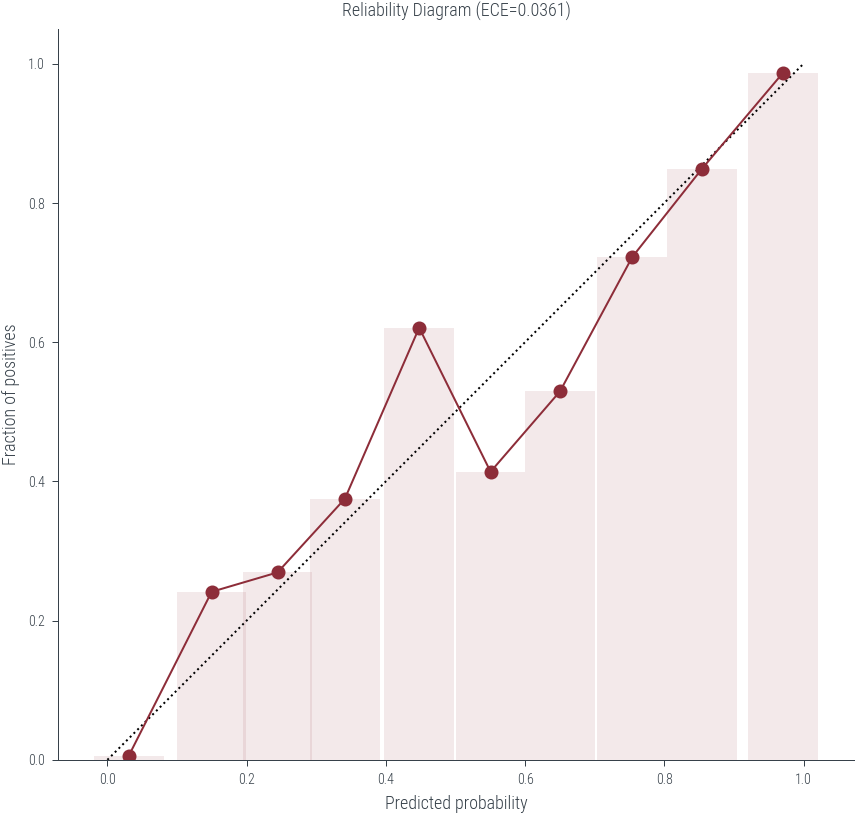

In [19]:
plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], 'k:')
plt.plot(mean_predicted_probs, fraction_of_positives, 'o-')
plt.xlabel('Predicted probability')
plt.ylabel('Fraction of positives')
plt.title(f'Reliability Diagram (ECE={ece:.4f})')
plt.gca().set_aspect('equal')

# Plot the bar also
plt.bar(mean_predicted_probs, fraction_of_positives, width=0.1, alpha=0.1)

In [20]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(df['y'], df['p_hat'], n_bins=10, strategy='uniform')


In [21]:
assert np.allclose(prob_true, fraction_of_positives)

In [22]:
assert np.allclose(prob_pred, mean_predicted_probs)

In [23]:
pd.DataFrame({'prob_true': prob_true, 'prob_pred': prob_pred})


,prob_true,prob_pred
0,0.006231,0.030912
1,0.241379,0.149753
2,0.269231,0.244433
3,0.375000,0.341098
4,0.620690,0.447832
5,0.413793,0.550410
6,0.529412,0.650223
7,0.722222,0.753892
8,0.849315,0.854304
9,0.987097,0.970665


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

def plot_reliability_diagram(classifier, X, y, n_bins=10, ax=None):
    """
    Generate a reliability diagram and calculate ECE for a classifier.

    Parameters:
    - classifier: A scikit-learn classifier with a `predict_proba` method.
    - X: Input features for the dataset.
    - y: True labels for the dataset.
    - n_bins: Number of bins for the reliability diagram.
    - ax: Matplotlib axes object to plot on.

    Returns:
    - ece: Expected Calibration Error (ECE).
    """
    if ax is None:
        fig, ax = plt.subplots()

    # Fit the classifier
    classifier.fit(X, y)

    # Predict probabilities
    p_hats = classifier.predict_proba(X)[:, 1]

    # Create a DataFrame
    df = pd.DataFrame({'p_hat': p_hats, 'y': y})

    # Create bins based on predicted probabilities
    bins = np.linspace(0, 1, n_bins + 1)
    df['bin'] = pd.cut(df['p_hat'], bins=bins)
    
    mean_predicted_probs = df.groupby('bin').p_hat.mean()
    fraction_of_positives = df.groupby('bin').y.mean()
    
    # Fill NANs with 0
    mean_predicted_probs = mean_predicted_probs.fillna(0)
    fraction_of_positives = fraction_of_positives.fillna(0)

    # Calculate the Expected Calibration Error (ECE) weighted by bin sizes
    bin_sizes = df.groupby('bin').size()
    
    # Ensure bin_sizes align with prob_true and prob_pred
    #bin_sizes = bin_sizes.reindex(range(n_bins), fill_value=0)
    #return bin_sizes, mean_predicted_probs, fraction_of_positives

    ece = (np.abs(mean_predicted_probs - fraction_of_positives) * bin_sizes / bin_sizes.sum()).sum()

    # Create the reliability diagram plot
    #plt.figure(figsize=(6, 6))
    ax.plot([0, 1], [0, 1], 'k:')
    ax.scatter(mean_predicted_probs, fraction_of_positives)
    # Plot bar also
    ax.bar(mean_predicted_probs, fraction_of_positives, width=0.1, alpha=0.1)
    ax.set_xlabel('Mean Predicted Probability')
    ax.set_ylabel('Fraction of Positives')
    ax.set_title(f'Calibration Curve (ECE={ece:.4f})')
    #plt.gca().set_aspect('equal')



    # Print the ECE
    print(f"Expected Calibration Error (ECE): {ece:.4f}")

# Example usage:
# classifier = LogisticRegression()  # Replace with your desired classifier
# X, y = make_moons(n_samples=1000, noise=0.1, random_state=0)  # Replace with your dataset
# plot_reliability_diagram(classifier, X, y)


Classifier: Logistic Regression
Expected Calibration Error (ECE): 0.0361
********************
********************


Classifier: Random Forest
Expected Calibration Error (ECE): 0.0135
********************
********************


Classifier: Support Vector Classifier
Expected Calibration Error (ECE): 0.0045
********************
********************


Classifier: K-Nearest Neighbors
Expected Calibration Error (ECE): 0.0013
********************
********************




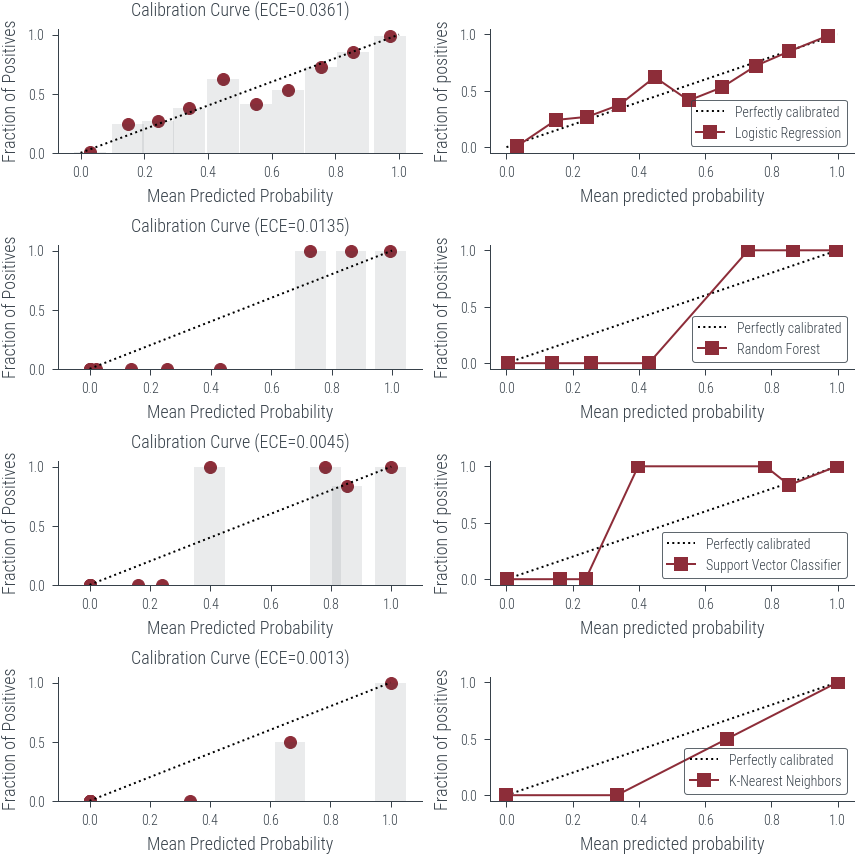

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibrationDisplay

# Generate the dataset
X, y = make_moons(n_samples=1000, noise=0.1, random_state=0)

# List of classifiers to evaluate
classifiers = [
    ('Logistic Regression', LogisticRegression()),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=0)),
    ('Support Vector Classifier', SVC(probability=True)),
    ('K-Nearest Neighbors', KNeighborsClassifier(n_neighbors=3))
]

fig, axarr = plt.subplots(figsize=(6, 6), nrows=len(classifiers), ncols=2)

# Loop through the classifiers and generate reliability diagrams
for i, (name, classifier) in enumerate(classifiers):
    print(f"Classifier: {name}")
    plot_reliability_diagram(classifier, X, y, ax=axarr[i, 0])
    
    CalibrationDisplay.from_estimator(
        classifier,
        X,
        y,
        n_bins=10,
        ax = axarr[i, 1],
        name=name
    )
    print("*"*20)
    print("*"*20)
    print("\n" + "=" * 50 + "\n")

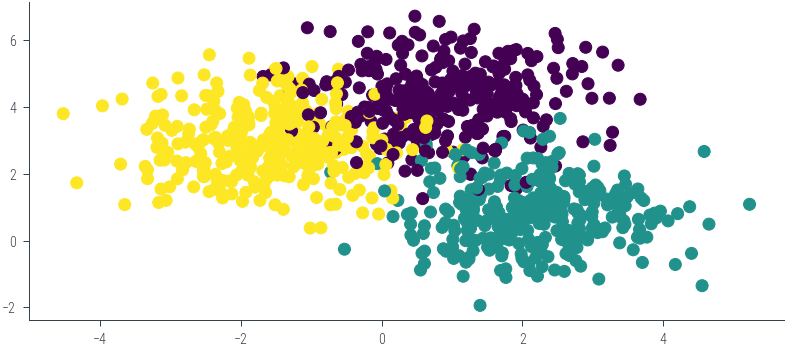

In [46]:
# Now, multi-class classification and reliability diagrams

from sklearn.datasets import make_classification, make_blobs

X, y = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=0)

# Plot the dataset
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')

In [68]:
clf = LogisticRegression()
clf.fit(X, y)

LogisticRegression()

In [69]:
preds = pd.DataFrame(clf.predict_proba(X))

In [70]:
preds

,0,1,2
0,0.068741,0.005454,0.925805
1,0.983384,0.015859,0.000757
2,0.021072,0.000240,0.978688
3,0.042703,0.001372,0.955925
4,0.000208,0.000026,0.999766
...,...,...,...
995,0.005001,0.994489,0.000510
996,0.050768,0.015765,0.933467
997,0.006151,0.911409,0.082440
998,0.000271,0.000021,0.999708


In [71]:
preds['y'] = y

In [72]:
preds.head(10)

,0,1,2,y
0,0.068741,0.005454,0.925805,2
1,0.983384,0.015859,0.000757,0
2,0.021072,0.000240,0.978688,2
3,0.042703,0.001372,0.955925,2
4,0.000208,0.000026,0.999766,2
5,0.179771,0.797045,0.023183,1
6,0.120874,0.003821,0.875305,0
7,0.957242,0.000002,0.042756,0
8,0.000908,0.998876,0.000216,1
9,0.836772,0.162509,0.000718,0


In [73]:
# Syntax highlighting to show highest amongst the three columns
most_probable_class = preds[[0, 1, 2]].idxmax(axis=1)

# Add the most probable class to the DataFrame
preds['y_hat'] = most_probable_class
preds.head()

,0,1,2,y,y_hat
0,0.068741,0.005454,0.925805,2,2
1,0.983384,0.015859,0.000757,0,0
2,0.021072,0.000240,0.978688,2,2
3,0.042703,0.001372,0.955925,2,2
4,0.000208,0.000026,0.999766,2,2
